<a href="https://colab.research.google.com/github/SangMin316/diagnosis-of-crop-disease/blob/main/efficientnet_b0%2B_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # 첫번째 gpu 쓰겠다.

### Data Load

In [ ]:
!pip install gdrive_dataset

In [ ]:
# https://drive.google.com/file/d/1DOYRWtzDlynJ0VJqDtdluzHXBzkJLZgE/view
# 위 주소가 데이터 다운받는 주소임, d/~~~/view. ~~가 file_id임
from gdrivedataset import loader

file_id = '1DOYRWtzDlynJ0VJqDtdluzHXBzkJLZgE'
loader.load_from_google_drive(file_id)

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of dataset.zip or
        dataset.zip.zip, and cannot find dataset.zip.ZIP, period.


In [ ]:
!unzip data/train.zip -d data/

unzip:  cannot find or open data/train.zip, data/train.zip.zip or data/train.zip.ZIP.


In [ ]:
!unzip data/test.zip -d data/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [ ]:
sample = glob('/content/drive/MyDrive/dacon/data/train/*')[42]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_csv

In [ ]:
csv_files = sorted(glob('/content/drive/MyDrive/dacon/data/train/*/*.csv'))#csv 파일들을 list로 받는다.

In [ ]:
for csv in tqdm(csv_files[1:20]): # 위 과정을 전체 csv파일에 적용해준다.
    temp_csv = pd.read_csv(csv)['내부 CO2 평균']
    print(temp_csv)

100%|██████████| 19/19 [00:00<00:00, 117.80it/s]

0      400.8
1      406.6
2      419.0
3      412.1
4      408.4
       ...  
289    433.9
290    439.0
291    442.5
292    443.1
293    465.1
Name: 내부 CO2 평균, Length: 294, dtype: float64
0      382.3
1      380.9
2      381.1
3      383.2
4      383.0
       ...  
289    378.5
290    377.2
291    378.9
292    377.4
293    377.9
Name: 내부 CO2 평균, Length: 294, dtype: float64
0      387.4
1      385.7
2      383.3
3      386.7
4      386.4
       ...  
289    382.5
290    384.3
291    383.7
292    382.3
293    384.0
Name: 내부 CO2 평균, Length: 294, dtype: float64
0      380.4
1      379.5
2      380.6
3      380.6
4      380.2
       ...  
289    379.5
290    377.6
291    378.0
292    378.4
293    376.4
Name: 내부 CO2 평균, Length: 294, dtype: float64
0          -
1      492.2
2          -
3      507.2
4          -
       ...  
583    483.8
584        -
585    490.5
586        -
587    495.2
Name: 내부 CO2 평균, Length: 588, dtype: object
0          -
1      529.4
2          -
3      540.3
4        

null값들이 들어간 column들이 존재,

csv파일에 공통적으로 null값들이 존재하는 column보이기

학습에 필요한 column들만 빠로 추출

# 데이터 로드

## 환경 데이터 통계량 계산 for MinMax Scaling

In [ ]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

temp_csv = pd.read_csv(csv_files[0])[csv_features] # list에 있는 첫번째 csv 파일의 csv_feature로 DataFrame을 만든다.
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy() # 각 feature의 max값,min 값을 받는다.

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]): # 위 과정을 전체 csv파일에 적용해준다.
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_csv = temp_csv.replace('-',np.nan).dropna() #'-'값 삭제
    if len(temp_csv) == 0:
        continue
    temp_csv = temp_csv.astype(float)
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0) # 기존에 구했던 max_arr과 새로 구한 temp_max중 큰 값을 max_arr로 설정
    min_arr = np.min([min_arr,temp_min], axis=0) # 기존에 구했던 min_arr과 새로 구한 temp_min중 큰 값을 min_arr로 설정

# feature 별 최대값, 최솟값 dictionary 생성
# 나중에 min-max scaling 할때 사용할거임
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 5766/5766 [21:18<00:00,  4.51it/s]


{'내부 습도 1 최고': [25.9, 100.0],
 '내부 습도 1 최저': [0.0, 100.0],
 '내부 습도 1 평균': [23.7, 100.0],
 '내부 온도 1 최고': [3.4, 47.6],
 '내부 온도 1 최저': [3.3, 47.0],
 '내부 온도 1 평균': [3.4, 47.3],
 '내부 이슬점 최고': [0.2, 34.7],
 '내부 이슬점 최저': [0.0, 34.4],
 '내부 이슬점 평균': [0.1, 34.5]}

## CustomDataset 제작

In [ ]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

In [ ]:
# key, value 꺼내는거 예시
for key, value in disease.items():
  print('key:',key,'value:',value)

In [ ]:
label_description = {}
for key, value in disease.items(): #disease에서 key와 value 하나씩 꺼내서 쓰겠다. 
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'# 정상인 친구들은 {key_00_0 : crop[key]_정상} 식으로 담겠다.
    for disease_code in value: # 병해가 있는거 차례대로
        for risk_code in risk: # risk 순서대로 명명하겠다.
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기')]

In [ ]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [ ]:
label_encoder

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

In [ ]:
device = torch.device("cuda:0")
batch_size = 16
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 256
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 8
vision_pretrain = True
save_path = 'best_model.pt'

# 데이터셋 구성

In [ ]:
train = sorted(glob('/content/drive/MyDrive/dacon/data/train/*'))
test = sorted(glob('/content/drive/MyDrive/dacon/data/test/*'))

labelsss = pd.read_csv('/content/drive/MyDrive/dacon/data/train.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [ ]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)
test_dataset = CustomDataset(test, mode = 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=16, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# 모델

## 이미지 분류 모델 : EfficientNet b0

이미지 분류 모델, 시계열 분석 모델을 바꿔가면서 실험을 했습니다.

이미지 분류 모델: ResNet 50, efficientNet b0~b4

시계열 분석 모델 : LSTM, GRU

In [ ]:
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.2):
        super(CNN_Encoder, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)

    def forward(self, inputs):
        # inputs = nn.Linear() 
        output = self.model(inputs)
        return output
        

## 시계열 모델 :GRU

In [ ]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.GRU(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n) # resnet out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

In [ ]:
class VanillaRNN(nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정하기.
    out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state를 반환한다.
    out = out.reshape(out.shape[0], -1) # many to many 전략
    out = self.fc(out)
    return out

## 앙상블

In [ ]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [ ]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


# 학습

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
def accuracy_function(real, pred):    
    real = real.cpu() # gpu에 있는 tensor를 cpu에 복사
    pred = torch.argmax(pred, dim=1).cpu() # tensor의 행별 최대값이 들어있는 인덱스 반환
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    #input 값을 gpu에 올리기
    img = batch_item['img'].to(device) 
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device) 
    if training is True:
        model.train()
        optimizer.zero_grad() # backword 하기전에 gradient 0으로 설정
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        # batch = batch.to(torch.float32)
        # batch_item = batch_item.to(torch.float32)
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model.state_dict(), save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
289it [02:18,  2.09it/s, Epoch=1, Loss=0.409071, Mean Loss=1.263620, Mean F-1=0.511202]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked)

# 학습 결과

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.savefig('efficient_b0+LSTM')
plt.show()

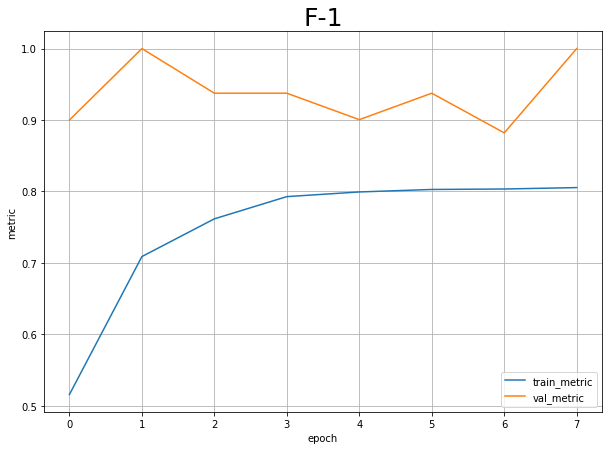

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.plot(val_metric_plot, label='val_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.savefig('efficient_b0+LSTM_F1')
plt.show()

# 추론

In [ ]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['csv_feature'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

preds = predict(test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
3245it [18:21,  2.95it/s]


In [ ]:
preds = np.array([label_decoder[int(val)] for val in preds])

# 제출 파일 생성

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission['label'] = preds
submission

,image,label
0,10000,6_00_0
1,10001,5_b6_1
2,10002,4_00_0
3,10003,3_00_0
4,10004,3_b8_1
...,...,...
51901,67673,4_00_0
51902,67674,3_b7_1
51903,67675,6_00_0
51904,67676,2_a5_2


In [ ]:
submission.to_csv('efficientnet_b0+lstm.csv', index=False)